In [ ]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import time
import warnings
warnings.filterwarnings("ignore")

In [2]:
pwt = pd.read_stata('data/pwt100.dta')
mrw = pd.read_stata('data/MRW1992.dta')

mrw_countries = mrw['country']
pwt.set_index(['country', 'year'], inplace=True)
not_found = []
not_found_PWT = ['Central African Republic', 'Congo', "Côte d'Ivoire",
                 'South Africa', 'U.R. of Tanzania: Mainland',
                 'D.R. of the Congo', 'Myanmar', 'China, Hong Kong SAR',
                 'Republic of Korea', 'Syrian Arab Republic', 'Germany',
                 'Dominican Republic', 'Trinidad and Tobago',
                 'Bolivia (Plurinational State of)', 'Venezuela (Bolivarian Republic of)']

for i, country in enumerate(mrw_countries[mrw['N']==1]):
    try:
        temp = np.log(np.mean(pwt.loc[country]['csh_i']))
    except Exception as e:
        print('key %s not found' % e)
        not_found.append(country)

key 'CentralAfr. Rep.' not found
key 'Congo, Peop. Rep.' not found
key 'Ivory Cost' not found
key 'Somalia' not found
key 'S. Africa' not found
key 'Tanzania' not found
key 'Zaire' not found
key 'Burma' not found
key 'Hong Kong' not found
key 'Korea, Rep. of' not found
key 'Syrian Arab Rep.' not found
key 'Germany, Fed. Rep.' not found
key 'Dominican Rep.' not found
key 'Trinidad & Tobago' not found
key 'Bolivia' not found
key 'Venezuela' not found
key 'Papua New Guinea' not found


In [3]:
mrw_pwt_countries = [n for n in mrw_countries[mrw['N']==1].tolist() if n not in not_found]
mrw_pwt_countries = mrw_pwt_countries + not_found_PWT

# Construct replication dataset based on observations for years 1985-2017
s = np.zeros(len(mrw_pwt_countries))
n = np.zeros(len(mrw_pwt_countries))
h = np.zeros(len(mrw_pwt_countries))
y_85 = np.zeros(len(mrw_pwt_countries))
y_17 = np.zeros(len(mrw_pwt_countries))

for i, country in enumerate(mrw_pwt_countries):
    s[i] = np.log(np.mean(pwt.loc[country]['csh_i'][35:]))
    n[i] = np.log(0.05+np.mean(pwt.loc[country]['emp'][35:].pct_change()))
    h[i] = np.mean(pwt.loc[country]['hc'][35:])
    y_85[i] = np.log(pwt.loc[country, 1985]['rgdpo']/pwt.loc[country, 1985]['emp'])
    y_17[i] = np.log(pwt.loc[country, 2017]['rgdpo']/pwt.loc[country, 2017]['emp'])

d = {'y_17': y_17, 'y_85': y_85, 's': s, 'δ_n_g': n, 's_h': np.log(np.log(h)*10)}
mrw_rep = pd.DataFrame(data=d, index=mrw_pwt_countries)
print(mrw_rep.head())

                   y_17       y_85         s     δ_n_g       s_h
Algeria       10.673525  11.235086 -1.145871 -2.514745  1.838571
Angola         9.602782   8.652294 -1.065619 -2.503920  0.974068
Benin          9.050662   8.656473 -1.878282 -2.508623  1.342471
Botswana      10.601112   9.596834 -1.302101 -2.517723  2.186768
Burkina Faso   8.637341   7.842568 -1.847810 -2.640430  0.072916


In [4]:
print('Task1 Unrestricted Estimation')
mrw_unrestricted = smf.ols('y_17 ~ s + δ_n_g + s_h', data=mrw_rep).fit()
print(mrw_unrestricted.summary())

Task1 Unrestricted Estimation
                            OLS Regression Results                            
Dep. Variable:                   y_17   R-squared:                       0.702
Model:                            OLS   Adj. R-squared:                  0.693
Method:                 Least Squares   F-statistic:                     71.61
Date:                Thu, 01 Dec 2022   Prob (F-statistic):           7.21e-24
Time:                        18:44:59   Log-Likelihood:                -95.617
No. Observations:                  95   AIC:                             199.2
Df Residuals:                      91   BIC:                             209.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.2195 

In [5]:
print('Task2 Restricted Estimation')
mrw_rep['restricted'] = mrw_rep['s'] - mrw_rep['δ_n_g']
mrw_rep['restricted_h'] = mrw_rep['s_h'] - mrw_rep['δ_n_g']
mrw_restricted = smf.ols('y_17 ~ restricted + restricted_h', data=mrw_rep).fit()
print(mrw_restricted.summary())

# alpha_beta = ((mrw_restricted.params[1]+mrw_restricted.params[2])/
#        (1+mrw_restricted.params[1]+mrw_restricted.params[2]))
# print('\nImplied alpha =', mrw_restricted.params[1] * (1-alpha_beta))
# print('Implied beta =', mrw_restricted.params[2] * (1-alpha_beta))

print('\nImplied alpha =', mrw_restricted.params[1] / 
     (1+mrw_restricted.params[1]+mrw_restricted.params[2]))
print('Implied beta =', mrw_restricted.params[2] / 
      (1+mrw_restricted.params[1]+mrw_restricted.params[2]))

print('Test of restriction p-value =', mrw_unrestricted.compare_f_test(mrw_restricted)[1])

Task2 Restricted Estimation
                            OLS Regression Results                            
Dep. Variable:                   y_17   R-squared:                       0.702
Model:                            OLS   Adj. R-squared:                  0.696
Method:                 Least Squares   F-statistic:                     108.5
Date:                Thu, 01 Dec 2022   Prob (F-statistic):           6.34e-25
Time:                        18:45:01   Log-Likelihood:                -95.658
No. Observations:                  95   AIC:                             197.3
Df Residuals:                      92   BIC:                             205.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        3.8

Task3 Convergence Estimation
                            OLS Regression Results                            
Dep. Variable:                y_17_85   R-squared:                       0.200
Model:                            OLS   Adj. R-squared:                  0.165
Method:                 Least Squares   F-statistic:                     5.639
Date:                Thu, 01 Dec 2022   Prob (F-statistic):           0.000427
Time:                        21:02:42   Log-Likelihood:                -81.212
No. Observations:                  95   AIC:                             172.4
Df Residuals:                      90   BIC:                             185.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.7581  

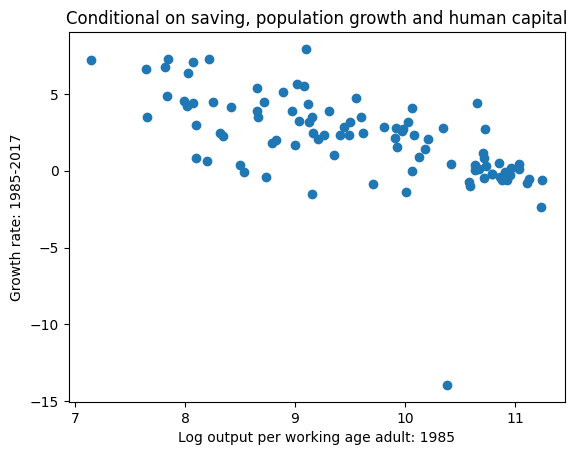

In [11]:
print('Task3 Convergence Estimation')
mrw_rep['y_17_85'] =  mrw_rep['y_17'] - mrw_rep['y_85'] 
mrw_convergence = smf.ols('y_17_85 ~ y_85 + s + δ_n_g + s_h', data=mrw_rep).fit()
print(mrw_convergence.summary())
print('\nImplied λ =', np.log(1+mrw_convergence.params[1])/(-32))

time.sleep(0.1)
par = mrw_convergence.params
plt.scatter(mrw_rep['y_85'],
            100/25*(mrw_rep['y_17_85']
                    - par[2]*(mrw_rep['s']-mrw_rep['s'].mean())
                    - par[3]*(mrw_rep['δ_n_g']-mrw_rep['δ_n_g'].mean())
                    - par[4]*(mrw_rep['s_h']-mrw_rep['s_h'].mean())))

plt.title('Conditional on saving, population growth and human capital')
plt.xlabel('Log output per working age adult: 1985')
plt.ylabel('Growth rate: 1985-2017')

plt.show()